In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter
from colorama import Fore,Style

import catboost

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold,train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve,classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.config import list_physical_devices
from tensorflow.random import set_seed
set_seed(42)

%matplotlib inline

In [2]:
df=pd.read_csv('post_natal_data.csv',delimiter=',',encoding='utf8')
pd.set_option('display.max_columns',None)
df.tail()

,Timestamp,Age,Feeling sad or Tearful,Irritable towards baby & partner,Trouble sleeping at night,Problems concentrating or making decision,Overeating or loss of appetite,Feeling anxious,Feeling of guilt,Problems of bonding with baby,Suicide attempt
1503,6/14/2022 23:45,45-50,No,No,No,No,No,No,No,No,No
1504,6/14/2022 23:45,40-45,No,No,No,No,No,No,No,No,No
1505,6/14/2022 23:45,35-40,No,No,No,No,No,No,No,No,No
1506,6/14/2022 23:45,30-35,No,No,No,No,No,No,No,No,No
1507,6/14/2022 23:45,25-30,No,No,No,No,No,No,No,No,No


In [3]:
print('Rows: ',df.shape[0])
print('Columns: ',df.shape[1])
print("\nFeatures: \n",df.columns.tolist())
print("\nnMissing values: ",df.isnull().sum().values.sum())
print("\nUnique values: \n",df.nunique())

Rows:  1508
Columns:  11

Features: 
 ['Timestamp', 'Age', 'Feeling sad or Tearful', 'Irritable towards baby & partner', 'Trouble sleeping at night', 'Problems concentrating or making decision', 'Overeating or loss of appetite', 'Feeling anxious', 'Feeling of guilt', 'Problems of bonding with baby', 'Suicide attempt']

nMissing values:  27

Unique values: 
 Timestamp                                    90
Age                                           5
Feeling sad or Tearful                        3
Irritable towards baby & partner              3
Trouble sleeping at night                     3
Problems concentrating or making decision     3
Overeating or loss of appetite                3
Feeling anxious                               2
Feeling of guilt                              3
Problems of bonding with baby                 3
Suicide attempt                               3
dtype: int64


In [4]:
df.drop('Timestamp',axis=1,inplace=True)
df.columns=df.columns.str.lower().str.replace(" ","_").str.replace("&", "and")
df.head()

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_anxious,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
0,35-40,Yes,Yes,Two or more days a week,Yes,Yes,Yes,No,Yes,Yes
1,40-45,Yes,No,No,Yes,Yes,No,Yes,Yes,No
2,35-40,Yes,No,Yes,Yes,Yes,Yes,No,Sometimes,No
3,35-40,Yes,Yes,Yes,Yes,No,Yes,Maybe,No,No
4,40-45,Yes,No,Two or more days a week,Yes,No,Yes,No,Yes,No


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        1508 non-null   object
 1   feeling_sad_or_tearful                     1508 non-null   object
 2   irritable_towards_baby_and_partner         1502 non-null   object
 3   trouble_sleeping_at_night                  1508 non-null   object
 4   problems_concentrating_or_making_decision  1496 non-null   object
 5   overeating_or_loss_of_appetite             1508 non-null   object
 6   feeling_anxious                            1508 non-null   object
 7   feeling_of_guilt                           1499 non-null   object
 8   problems_of_bonding_with_baby              1508 non-null   object
 9   suicide_attempt                            1508 non-null   object
dtypes: object(10)
memory usage: 117.9+ K

In [6]:
df.describe(include='all').T

,count,unique,top,freq
age,1508,5,40-45,365
feeling_sad_or_tearful,1508,3,Yes,536
irritable_towards_baby_and_partner,1502,3,Yes,555
trouble_sleeping_at_night,1508,3,Two or more days a week,640
problems_concentrating_or_making_decision,1496,3,No,588
overeating_or_loss_of_appetite,1508,3,No,846
feeling_anxious,1508,2,Yes,980
feeling_of_guilt,1499,3,No,629
problems_of_bonding_with_baby,1508,3,No,562
suicide_attempt,1508,3,No,714


In [7]:
col_name=df.select_dtypes(include='object').columns
for idx,col in enumerate(col_name):
  print(f'\033[1;3m{col_name[idx]}:\033[0m\n{df[col].value_counts()}\n')

age:
age
40-45    365
35-40    350
30-35    339
45-50    272
25-30    182
Name: count, dtype: int64

feeling_sad_or_tearful:
feeling_sad_or_tearful
Yes          536
No           529
Sometimes    443
Name: count, dtype: int64

irritable_towards_baby_and_partner:
irritable_towards_baby_and_partner
Yes          555
No           504
Sometimes    443
Name: count, dtype: int64

trouble_sleeping_at_night:
trouble_sleeping_at_night
Two or more days a week    640
Yes                        445
No                         423
Name: count, dtype: int64

problems_concentrating_or_making_decision:
problems_concentrating_or_making_decision
No       588
Often    473
Yes      435
Name: count, dtype: int64

overeating_or_loss_of_appetite:
overeating_or_loss_of_appetite
No            846
Yes           343
Not at all    319
Name: count, dtype: int64

feeling_anxious:
feeling_anxious
Yes    980
No     528
Name: count, dtype: int64

feeling_of_guilt:
feeling_of_guilt
No       629
Maybe    528
Yes      342
N

In [8]:
col_name=df.select_dtypes(include='object').columns
for index, col in enumerate(col_name):
  print(f'\033[1;3m{col_name[index]} (%):\033[0m\n{np.round(df[col].value_counts(normalize=True)*100, 1)}\n')

age (%):
age
40-45    24.2
35-40    23.2
30-35    22.5
45-50    18.0
25-30    12.1
Name: proportion, dtype: float64

feeling_sad_or_tearful (%):
feeling_sad_or_tearful
Yes          35.5
No           35.1
Sometimes    29.4
Name: proportion, dtype: float64

irritable_towards_baby_and_partner (%):
irritable_towards_baby_and_partner
Yes          37.0
No           33.6
Sometimes    29.5
Name: proportion, dtype: float64

trouble_sleeping_at_night (%):
trouble_sleeping_at_night
Two or more days a week    42.4
Yes                        29.5
No                         28.1
Name: proportion, dtype: float64

problems_concentrating_or_making_decision (%):
problems_concentrating_or_making_decision
No       39.3
Often    31.6
Yes      29.1
Name: proportion, dtype: float64

overeating_or_loss_of_appetite (%):
overeating_or_loss_of_appetite
No            56.1
Yes           22.7
Not at all    21.2
Name: proportion, dtype: float64

feeling_anxious (%):
feeling_anxious
Yes    65.0
No     35.0
Name: prop

In [9]:
df.isnull().sum()

age                                           0
feeling_sad_or_tearful                        0
irritable_towards_baby_and_partner            6
trouble_sleeping_at_night                     0
problems_concentrating_or_making_decision    12
overeating_or_loss_of_appetite                0
feeling_anxious                               0
feeling_of_guilt                              9
problems_of_bonding_with_baby                 0
suicide_attempt                               0
dtype: int64

In [10]:
df.dropna(inplace=True) 
df.isna().sum()

age                                          0
feeling_sad_or_tearful                       0
irritable_towards_baby_and_partner           0
trouble_sleeping_at_night                    0
problems_concentrating_or_making_decision    0
overeating_or_loss_of_appetite               0
feeling_anxious                              0
feeling_of_guilt                             0
problems_of_bonding_with_baby                0
suicide_attempt                              0
dtype: int64

In [11]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [12]:
val_yes,val_no=df['feeling_anxious'].value_counts(normalize=True)*100
val_yes,val_no

(64.70588235294117, 35.294117647058826)

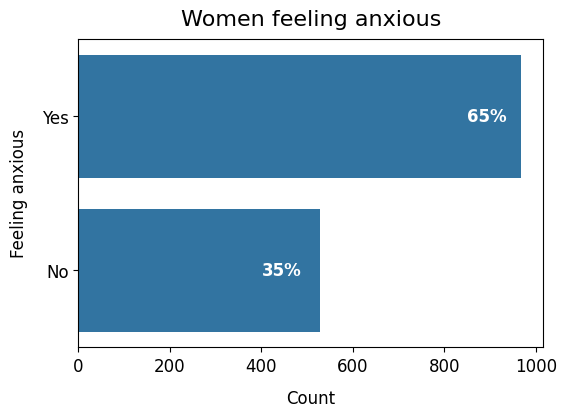

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(y='feeling_anxious', data=df)
plt.xlabel(xlabel='Count',fontsize=12,labelpad=10)
plt.ylabel(ylabel='Feeling anxious',fontsize=12,labelpad=10)
plt.text(x=850,y=0,s=str(int(np.round(val_yes)))+"%",fontsize=12,fontweight='bold',color='w',va='center')
plt.text(x=400,y=1,s=str(int(np.round(val_no)))+"%",fontsize=12,fontweight='bold',color='w',va='center')
plt.title(label='Women feeling anxious',fontsize=16,pad=10)
plt.tick_params(axis='both',labelsize=12)

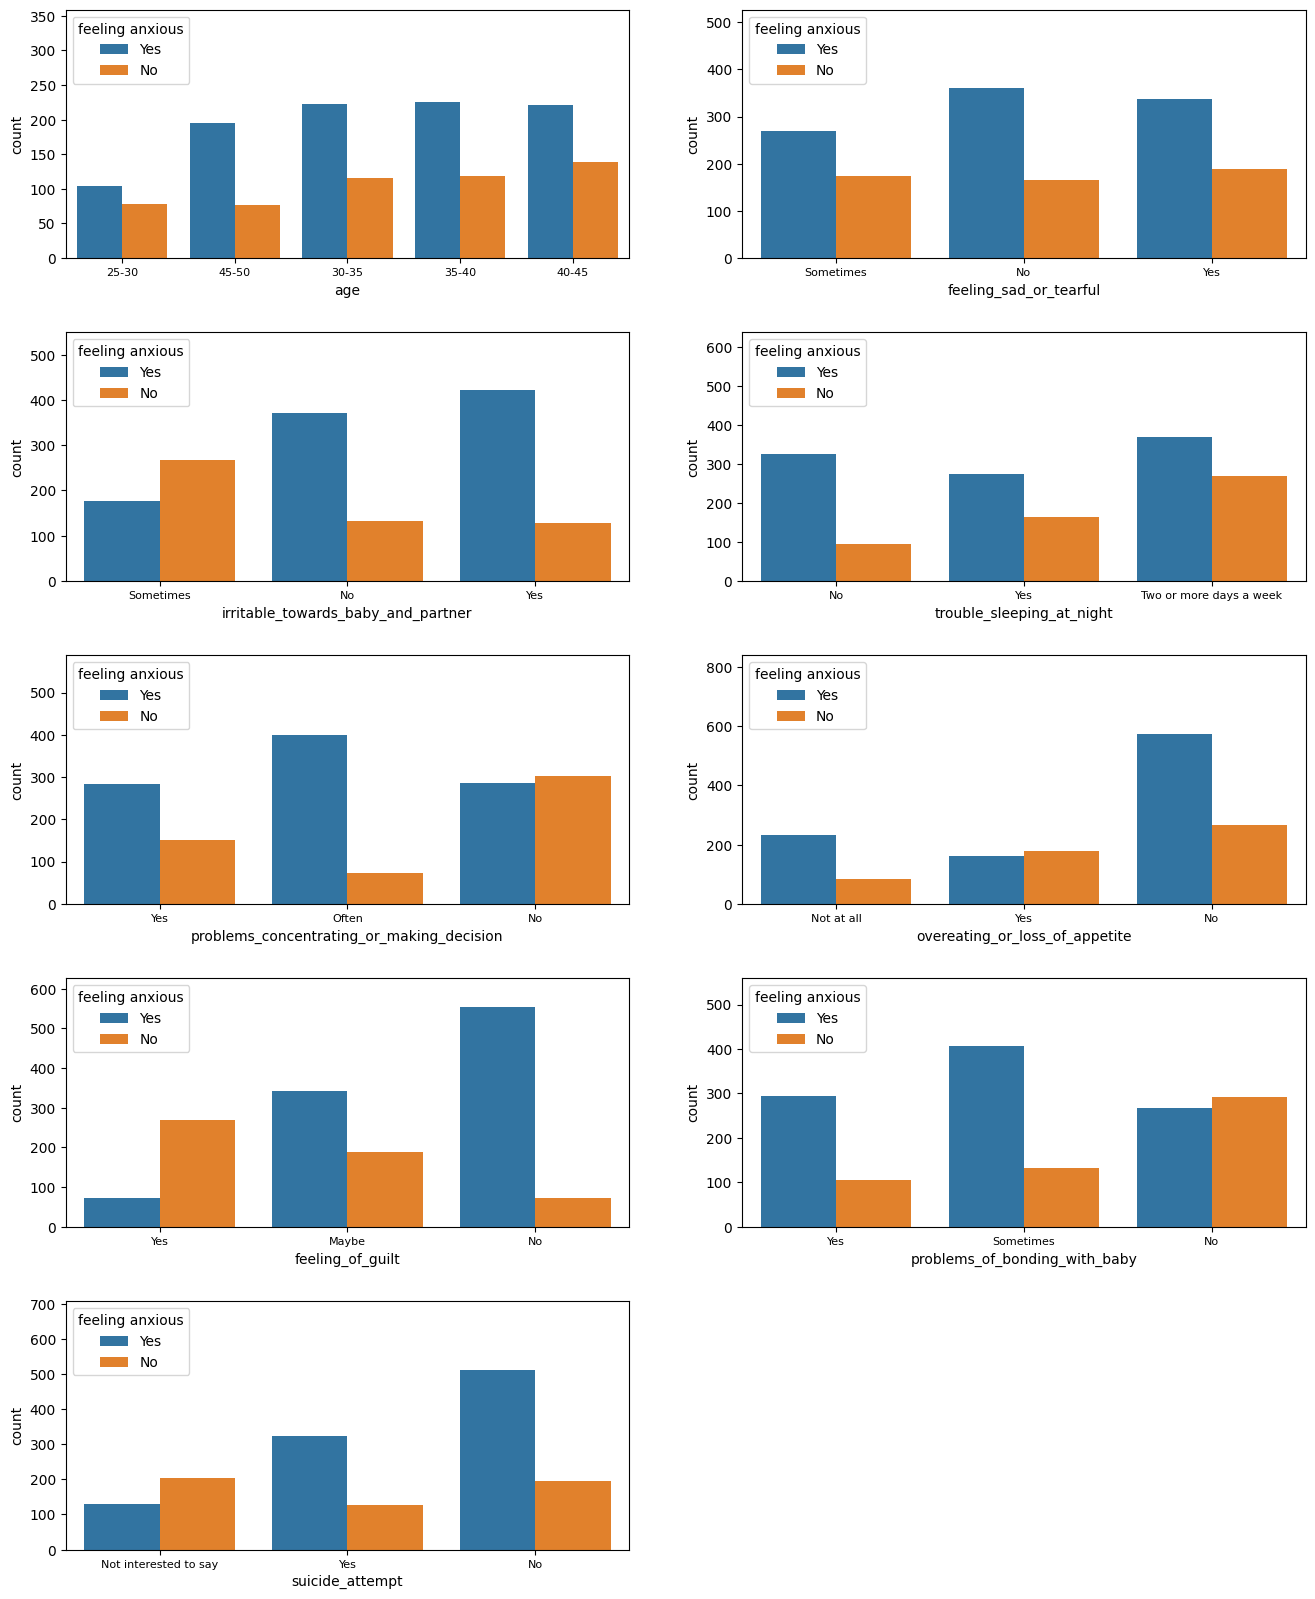

In [14]:
columns=[c for c in df.columns if c!='feeling_anxious']
fig,axes=plt.subplots(5,2,figsize=(16,20),sharey=False)
axes[4,1].set_axis_off()

for name,ax in zip(columns,axes.flatten()):
  sns.countplot(x=name, hue='feeling_anxious',data=df,order=df[name].value_counts(ascending=True).index, ax=ax)
  ax.tick_params(axis='x',labelsize=8)
  ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
  ax.set_ylim([0, max(df[name].value_counts())])
  ax.legend(title='feeling anxious', loc='upper left')
  plt.subplots_adjust(hspace=0.3);

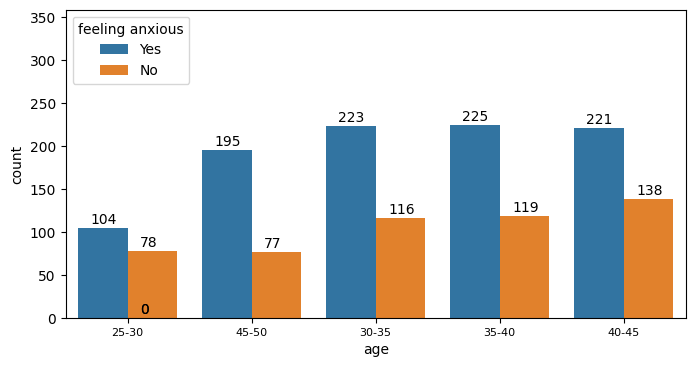

In [15]:
name='age'

fig, ax = plt.subplots(1, 1, figsize=(8,4), sharey=False)

sns.countplot(x=name, hue='feeling_anxious', data=df, order=df[name].value_counts(ascending=True).index, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.subplots_adjust(hspace=0.3)
ax.set_ylim([0, max(df[name].value_counts())])
ax.legend(title='feeling anxious', loc='upper left')

for p in ax.patches:
    txt = str(int(np.round(p.get_height())))
    x = p.get_x()+0.1
    y = p.get_height()+5
    ax.text(x, y, txt);

# model

In [16]:
def summary_report_tree(model,X_test,y_test):
  y_pred=model.predict(X_test)
  y_test_prob=model.predict_proba(X_test)[:,1]
  
  accuracy_=accuracy_score(y_test,y_pred)
  precision_=precision_score(y_test,y_pred)
  recall_=recall_score(y_test,y_pred)
  f1_=f1_score(y_test,y_pred)
  roc_auc_=roc_auc_score(y_test,y_pred)
  print(f'\033[1mSummary Report\033[0m')
  print(f'\033[1mAccuracy:  {accuracy_:.2f}\033[0m [TP / N] Proportion of predicted labels that match true labels')
  print(f'\033[1mPrecision: {precision_:.2f}\033[0m [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative')
  print(f'\033[1mRecall:    {recall_:.2f}\033[0m [TP / (TP + FN)] Ability of the classifier to find all positive samples')
  print(f'\033[1mF1-score:  {f1_:.2f}\033[0m [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall')
  print(f'\033[1mROC AUC:   {roc_auc_:.2f}\033[0m')
  print(113*'-')
  print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
  print(113*'-', '\n')
  
  mat=confusion_matrix(y_test,y_pred)
  precision, recall,_=precision_recall_curve(y_test,y_test_prob)
  
  fpr,tpr,_=roc_curve(y_test,y_test_prob)
  roc_auc=auc(fpr,tpr)
  
  fig,ax=plt.subplots(1,3,figsize=(18,6))
  fig.subplots_adjust(left=0.02,right=0.98,wspace=0.2)
  
  group_names=['TN','FP','FN','TP']
  group_counts=["{0:0.0f}".format(value) for value in mat.flatten()]
  labels=[f"{v1}\n\n{v2}" for v1,v2 in zip(group_names,group_counts)]
  labels=np.asarray(labels).reshape(2,2)
  
  sns.heatmap(mat,annot=labels,cmap=plt.cm.Blues,fmt="",ax=ax[0])
  ax[0].set_title('Confusion Matrix')
  ax[0].set_xlabel('Predicted label')
  ax[0].set_ylabel('True label')

  step_kwargs = {'step': 'post'}
  ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
  ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
  ax[1].set_ylim([0.0, 1.0])
  ax[1].set_xlim([0.0, 1.0])
  ax[1].set_xlabel('Recall')
  ax[1].set_ylabel('Precision')
  ax[1].set_title('2-class Precision-Recall curve')

  ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
  ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax[2].set_xlim([0.0, 1.0])
  ax[2].set_ylim([0.0, 1.0])
  ax[2].set_xlabel('False Positive Rate (1-specificity)')
  ax[2].set_ylabel('True Positive Rate (sensitivity)')
  ax[2].set_title('Receiver Operating Characteristic')
  ax[2].legend(loc='lower right')
  
  plt.show()
  
  return accuracy_,precision_,recall_,f1_,roc_auc_

In [17]:
def summary_report_nn(model,X_test,y_test):
  y_pred = ((model.predict(X_test)>0.5)*1).flatten()
  
  y_test_prob = model.predict(X_test)

  accuracy_ = accuracy_score(y_test, y_pred)
  precision_ = precision_score(y_test, y_pred)
  recall_ = recall_score(y_test, y_pred)
  f1_ = f1_score(y_test, y_pred)
  roc_auc_ = roc_auc_score(y_test, y_pred)

  print(f'\n\033[1mSummary Report\033[0m')
  print(f'\033[1mAccuracy:  {accuracy_:.2f}\033[0m [TP / N] Proportion of predicted labels that match true labels')
  print(f'\033[1mPrecision: {precision_:.2f}\033[0m [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative')
  print(f'\033[1mRecall:    {recall_:.2f}\033[0m [TP / (TP + FN)] Ability of the classifier to find all positive samples')
  print(f'\033[1mF1-score:  {f1_:.2f}\033[0m [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall')
  print(f'\033[1mROC AUC:   {roc_auc_:.2f}\033[0m')
  print(113*'-')
  print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
  print(113*'-', '\n')
    
  mat = confusion_matrix(y_test, y_pred)
      
  precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
  
  fpr, tpr, _ = roc_curve(y_test, y_test_prob)
  roc_auc = auc(fpr, tpr)

  fig, ax = plt.subplots(1, 3, figsize=(18, 6))
  fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
  labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
  labels = np.asarray(labels).reshape(2,2)
    
  sns.heatmap(mat, annot=labels, cmap=plt.cm.Blues, fmt="", ax=ax[0])
  ax[0].set_title('Confusion Matrix')
  ax[0].set_xlabel('Predicted label')
  ax[0].set_ylabel('True label')

  step_kwargs = {'step': 'post'}
  ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
  ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
  ax[1].set_ylim([0.0, 1.0])
  ax[1].set_xlim([0.0, 1.0])
  ax[1].set_xlabel('Recall')
  ax[1].set_ylabel('Precision')
  ax[1].set_title('2-class Precision-Recall curve')

  ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
  ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  ax[2].set_xlim([0.0, 1.0])
  ax[2].set_ylim([0.0, 1.0])
  ax[2].set_xlabel('False Positive Rate (1-specificity)')
  ax[2].set_ylabel('True Positive Rate (sensitivity)')
  ax[2].set_title('Receiver Operating Characteristic')
  ax[2].legend(loc='lower right')
    
  plt.show()
    
  return accuracy_, precision_, recall_, f1_, roc_auc_

In [18]:
def plot_feature_importance(data,dist):
  fig,ax=plt.subplots(1,1,figsize=(6,8),sharey=False)
  sns.barplot(x='feature_importance',y='feature',data=data)
  ax.set_xlabel(xlabel='Feature importance',fontsize=12,labelpad=10)
  ax.set_ylabel(ylabel='Feature',fontsize=12,labelpad=10)
  ax.set_title(label='Feature importance',fontsize=16,pad=10)
  ax.tick_params(axis='both',labelsize=9)
  ax.set_xlim([0,max(data['feature_importance'])*1.2])
  
  for p in ax.patches:
    width=p.get_width()
    x=p.get_width()+dist
    y=p.get_y()+0.55*p.get_height()
    plt.text(x,y,'{:1.2f}'.format(width),ha='center',va='center')

In [19]:
def learning_curve_catboost(history):
  plt.figure(figsize=(6,4))
  plt.plot(history['validation_0']['Logloss'],color='r',label="Training")
  plt.plot(history['validation_1']['Logloss'],color='b',label="Testing")
  plt.legend(loc="upper right")
  plt.xlabel("Number of iterations",fontsize=16)
  plt.ylabel("Logloss",fontsize=16)
  plt.ylim([0,max(history['validation_0']['Logloss'])+0.1])
  plt.title(f"Learning Curve: CatBoost",fontsize=16)

In [20]:
def learning_curve_nn(history):
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))
      
  ax[0].plot(history.history["loss"], color="r", label="Training Loss")
  ax[0].plot(history.history["val_loss"], color="b", label="Validation Loss")
  ax[0].legend(loc="upper right")
  ax[0].set_xlabel("Epoch", fontsize=14)
  ax[0].set_ylabel("Loss", fontsize=14)
  ax[0].set_ylim([0, max(history.history["loss"])+1])
  ax[0].set_title("Training and Validation Loss", fontsize=16)
    
  ax[1].plot(history.history["accuracy"], color="r", label="Training Loss")
  ax[1].plot(history.history["val_accuracy"], color="b", label="Validation Loss")
  ax[1].legend(loc="best")
  ax[1].set_xlabel("Epoch", fontsize=14)
  ax[1].set_ylabel("Accuracy", fontsize=14)
  ax[1].set_ylim([0, max(history.history["accuracy"])+0.05])
  ax[1].set_title("Training and Validation Accuracy", fontsize=16)

In [21]:
df=shuffle(df,random_state=42)
target='feeling_anxious'

X=df.drop(columns=target,axis=1).copy()
y=df[target].copy()

In [22]:
X.head(3)

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
926,40-45,Sometimes,No,No,Often,No,Maybe,Yes,No
1362,30-35,Yes,No,Two or more days a week,No,Not at all,No,Sometimes,Yes
1069,45-50,Sometimes,Yes,No,Often,Not at all,No,Sometimes,No


In [23]:
y[:5]

926     Yes
1362    Yes
1069    Yes
536      No
517     Yes
Name: feeling_anxious, dtype: object

In [24]:
X.isna().sum()

age                                          0
feeling_sad_or_tearful                       0
irritable_towards_baby_and_partner           0
trouble_sleeping_at_night                    0
problems_concentrating_or_making_decision    0
overeating_or_loss_of_appetite               0
feeling_of_guilt                             0
problems_of_bonding_with_baby                0
suicide_attempt                              0
dtype: int64

In [25]:
age_group={'25-30':1,'30-35':2,'35-40':3,'40-45':4,'45-50':5}
X['age']=X['age'].map(age_group)
X.sample(3)

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
182,1,No,Yes,No,No,Not at all,Yes,Yes,Yes
1403,4,Yes,No,No,Often,Yes,No,Sometimes,No
504,2,Yes,No,Two or more days a week,No,Not at all,No,Sometimes,Yes


In [26]:
X=pd.get_dummies(data=X,columns=X.columns[1:])
X.head()

,age,feeling_sad_or_tearful_No,feeling_sad_or_tearful_Sometimes,feeling_sad_or_tearful_Yes,irritable_towards_baby_and_partner_No,irritable_towards_baby_and_partner_Sometimes,irritable_towards_baby_and_partner_Yes,trouble_sleeping_at_night_No,trouble_sleeping_at_night_Two or more days a week,trouble_sleeping_at_night_Yes,problems_concentrating_or_making_decision_No,problems_concentrating_or_making_decision_Often,problems_concentrating_or_making_decision_Yes,overeating_or_loss_of_appetite_No,overeating_or_loss_of_appetite_Not at all,overeating_or_loss_of_appetite_Yes,feeling_of_guilt_Maybe,feeling_of_guilt_No,feeling_of_guilt_Yes,problems_of_bonding_with_baby_No,problems_of_bonding_with_baby_Sometimes,problems_of_bonding_with_baby_Yes,suicide_attempt_No,suicide_attempt_Not interested to say,suicide_attempt_Yes
926,4,False,True,False,True,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False
1362,2,False,False,True,True,False,False,False,True,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,True
1069,5,False,True,False,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,True,False,False
536,2,True,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False
517,3,False,False,True,True,False,False,True,False,False,False,False,True,True,False,False,True,False,False,False,False,True,False,True,False


In [27]:
test_size=0.2
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=test_size,stratify=y)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1196, 25), (300, 25), (1196,), (300,))

In [28]:
X_train[:2]

,age,feeling_sad_or_tearful_No,feeling_sad_or_tearful_Sometimes,feeling_sad_or_tearful_Yes,irritable_towards_baby_and_partner_No,irritable_towards_baby_and_partner_Sometimes,irritable_towards_baby_and_partner_Yes,trouble_sleeping_at_night_No,trouble_sleeping_at_night_Two or more days a week,trouble_sleeping_at_night_Yes,problems_concentrating_or_making_decision_No,problems_concentrating_or_making_decision_Often,problems_concentrating_or_making_decision_Yes,overeating_or_loss_of_appetite_No,overeating_or_loss_of_appetite_Not at all,overeating_or_loss_of_appetite_Yes,feeling_of_guilt_Maybe,feeling_of_guilt_No,feeling_of_guilt_Yes,problems_of_bonding_with_baby_No,problems_of_bonding_with_baby_Sometimes,problems_of_bonding_with_baby_Yes,suicide_attempt_No,suicide_attempt_Not interested to say,suicide_attempt_Yes
943,4,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False,True,False,False,True,False,False
1014,4,False,False,True,False,False,True,True,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False


In [29]:
y_train[:5]

943     Yes
1014    Yes
1075     No
75       No
1311     No
Name: feeling_anxious, dtype: object

In [30]:
y_test[:5]

333     Yes
1190     No
274      No
779     Yes
1199    Yes
Name: feeling_anxious, dtype: object

In [31]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

print(y_train.shape,y_test.shape)
y_train

(1196,) (300,)


array([1, 1, 0, ..., 0, 1, 1], shape=(1196,))

In [32]:
plt.style.use('default')

In [33]:
cbc=catboost.CatBoostClassifier(verbose=0,random_state=42)
cbc.fit(X_train,y_train)

In [34]:
cbc.score(X_train,y_train)

np.float64(1.0)

In [35]:
cbc.score(X_test,y_test)

np.float64(1.0)

In [36]:
cv=RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
scores=cross_val_score(cbc,X_train,y_train,cv=cv,n_jobs=1)
print(f'Scores:\n{scores}\n')
print(f'\033[1;3mCatBoost; Cross-validation mean accuracy score and standard deviation: {scores.mean():.3f} +/-{scores.std():.3f}\033[0m')

Scores:
[1.         0.98333333 0.975      0.94166667 0.98333333 0.94166667
 0.99159664 0.99159664 0.97478992 0.98319328 0.99166667 0.95833333
 0.99166667 0.975      0.975      1.         0.98319328 0.98319328
 0.99159664 0.99159664 0.96666667 0.98333333 0.95833333 0.99166667
 0.975      0.96666667 0.97478992 0.97478992 0.98319328 0.99159664]

CatBoost; Cross-validation mean accuracy score and standard deviation: 0.979 +/-0.015


In [37]:
evalset=[(X_train,y_train),(X_test, y_test)]
cbc.fit(X_train,y_train,eval_set=evalset,use_best_model=True,verbose=0)

In [38]:
results=cbc.evals_result_
results.keys()

dict_keys(['learn', 'validation_0', 'validation_1'])

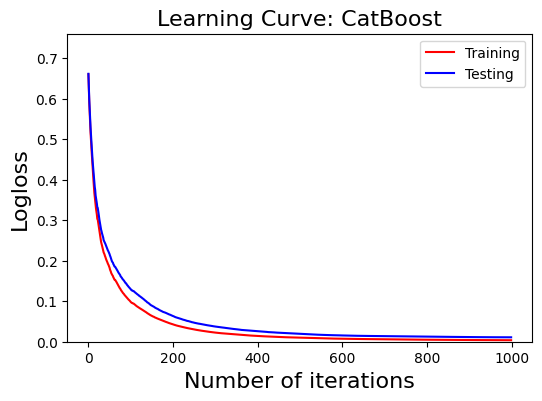

In [39]:
learning_curve_catboost(results)

In [40]:
%%time
cbc = catboost.CatBoostClassifier(verbose=0, random_state=42)

param_grid={'max_depth':range(3,11,1),
            'learning_rate':[0.01,0.02,0.03,0.04],
            'iterations':[300,400,500,1000]}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

cbc_rs = RandomizedSearchCV(cbc, param_distributions=param_grid, n_iter=40, n_jobs=1, cv=cv, verbose=0, random_state=42)
cbc_rs.fit(X_train,y_train)

CPU times: total: 1h 48min 54s
Wall time: 12min 1s


,estimator,<catboost.cor...0028BD25332F0>
,param_distributions,"{'iterations': [300, 400, ...], 'learning_rate': [0.01, 0.02, ...], 'max_depth': range(3, 11)}"
,n_iter,40
,scoring,None
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [41]:
print(cbc_rs.best_score_,cbc_rs.best_params_)

0.9807601115760113 {'max_depth': 10, 'learning_rate': 0.02, 'iterations': 400}


In [42]:
cbc_rs.best_estimator_

In [43]:
cbc_rs.score(X_train,y_train)

np.float64(1.0)

In [44]:
cbc_rs.score(X_test,y_test)

np.float64(1.0)

In [45]:
evalset=[(X_train,y_train),(X_test, y_test)]
cbc=catboost.CatBoostClassifier(iterations=500,learning_rate=0.03,max_depth=7,random_state=42,loss_function='Logloss')
cbc.fit(X_train,y_train,eval_set=evalset,verbose=0)

In [46]:
results=cbc.evals_result_
results.keys()

dict_keys(['learn', 'validation_0', 'validation_1'])

In [47]:
cbc.fit(X_train,y_train,verbose=0)
cbc_feature_importance=pd.DataFrame(zip(X_train.columns,cbc.feature_importances_),columns=['feature','feature_importance']).sort_values(by='feature_importance',ascending=False)
cbc_feature_importance

,feature,feature_importance
18,feeling_of_guilt_Yes,12.290029
0,age,6.829766
19,problems_of_bonding_with_baby_No,6.235217
10,problems_concentrating_or_making_decision_No,5.945870
9,trouble_sleeping_at_night_Yes,5.163590
17,feeling_of_guilt_No,4.967622
5,irritable_towards_baby_and_partner_Sometimes,4.849363
15,overeating_or_loss_of_appetite_Yes,4.714588
4,irritable_towards_baby_and_partner_No,4.188107
16,feeling_of_guilt_Maybe,3.768909


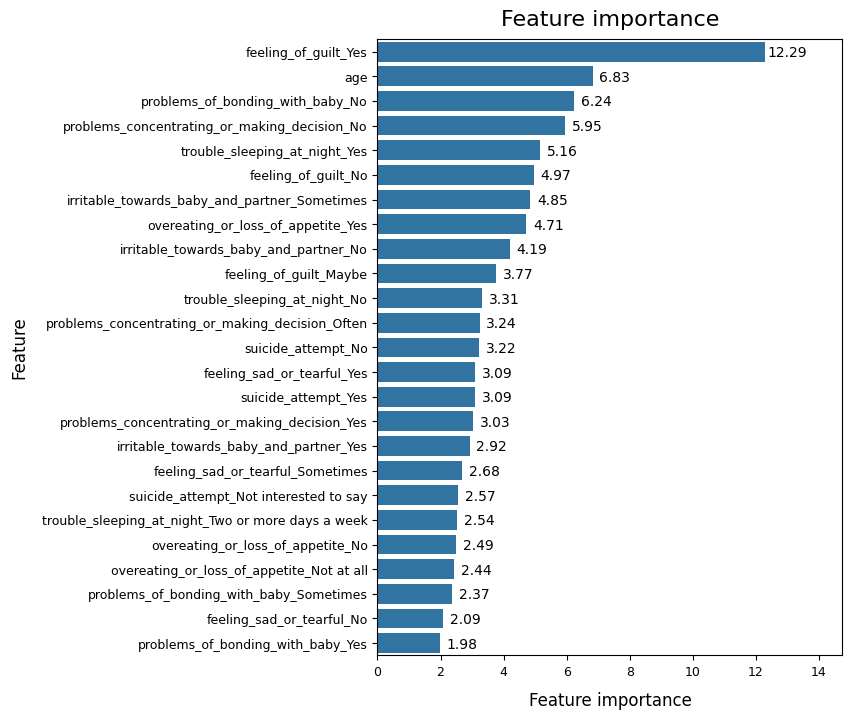

In [48]:
plot_feature_importance(cbc_feature_importance,dist=0.7)

Summary Report
Accuracy:  0.99 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.98 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.99 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.99
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



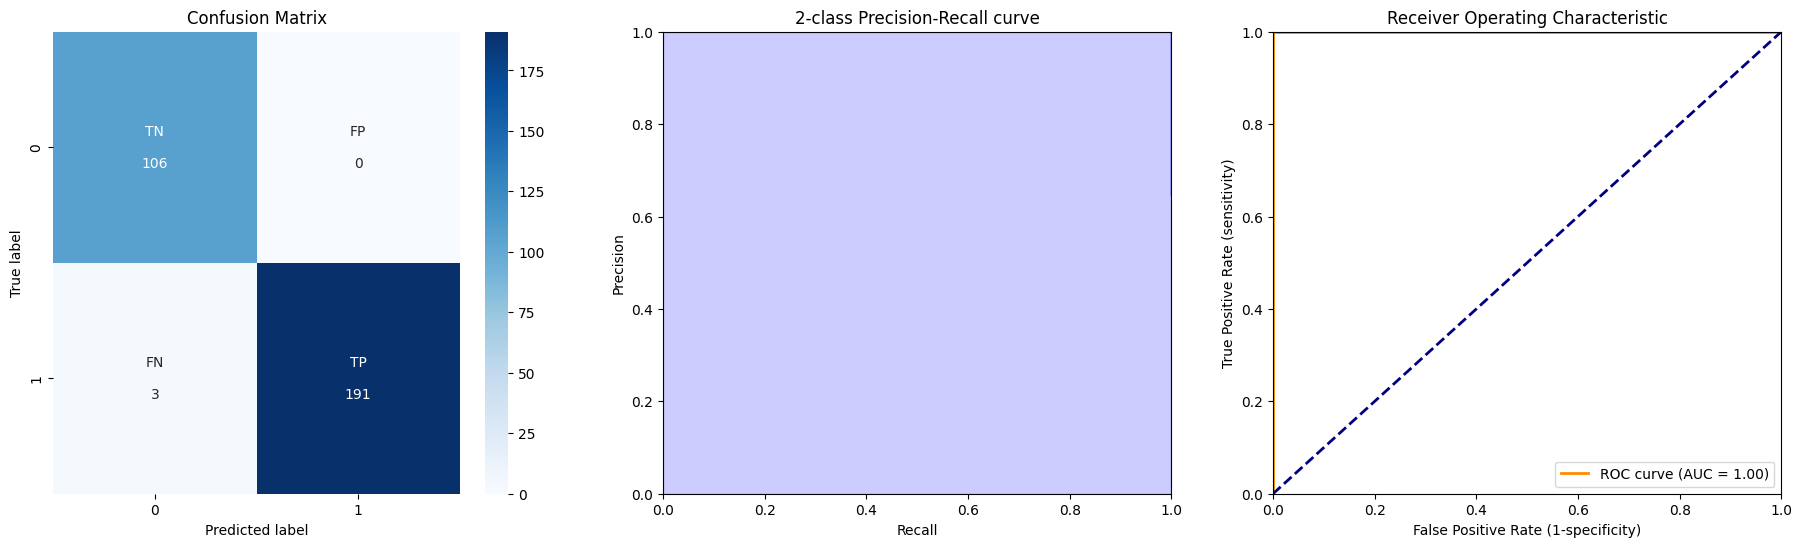

,Model,Set,Accuracy,Precision,Recall,F1-score,ROC AUC
0,CatBoost,Test,0.99,1.0,0.985,0.992,0.992


In [49]:
column_names=['Model','Set','Accuracy','Precision','Recall','F1-score','ROC AUC']
results_df=pd.DataFrame(columns=column_names)

accuracy_,precision_,recall_,f1_,roc_auc_=summary_report_tree(cbc,X_test,y_test)
list=[accuracy_,precision_,recall_,f1_,roc_auc_]
accuracy_,precision_,recall_,f1_,roc_auc_=[round(x,3) for x in list]

results_df.loc[len(results_df)]=['CatBoost','Test',accuracy_,precision_,recall_,f1_,roc_auc_]
results_df.sort_values(by='F1-score',ascending=False)

In [50]:
y_pred=cbc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       106
           1       1.00      0.98      0.99       194

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [51]:
import pickle

model_filename = 'post_natal_model.pkl'

with open(model_filename, 'wb') as file:
  pickle.dump(cbc, file)

print(f"CatBoost model saved successfully to {model_filename}")

CatBoost model saved successfully to post_natal_model.pkl
